# Tutorial

## Overview

Welcome to aurora-asi-lib. This tutorial will guide you though the main functions in `aurora-asi-lib` (imported as `asilib`). 

First off, we need to import the necessary packages. While cartopy is an optional dependency of many functions in `asilib`, we need it here to make maps (this notebook will crash when executing `asilib.plot_map`).

In [1]:
from datetime import datetime, timedelta
from IPython.display import Video
import numpy as np

import matplotlib.pyplot as plt
import asilib

plt.style.use('dark_background')

print(f'asilib version: {asilib.__version__}')

/home/mike/research/aurora-asi-lib/env/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


asilib version: 0.10.2


First of all, you should know where the data and movies are saved to. This information is in `asilib.config` and can be changed with `python3 -m asilib config` to configure asilib.

In [2]:
asilib.config

{'ASILIB_DIR': PosixPath('/home/mike/research/aurora-asi-lib/asilib'),
 'ASI_DATA_DIR': PosixPath('/media/mike/2D6742F55A2E0A82/asilib-data')}

As you can guess, `asilib.config['ASILIB_DIR']` is the directory where this code resides, `asilib.config['ASI_DATA_DIR']` is the directory where the data is saved to.

## Plot a single image

Since we sold you on easily downloading, loading, plotting and analyzing auroral images with `asilib`, lets begin with a plot of an omega band studied in:

Liu, J., Lyons, L. R., Archer, W. E., Gallardo-Lacourt, B., Nishimura, Y., Zou, 
Y., … Weygand, J. M. (2018). Flow shears at the poleward boundary of omega bands 
observed during conjunctions of Swarm and THEMIS ASI. Geophysical Research Letters, 
45, 1218– 1227. https://doi.org/10.1002/2017GL076485

We can plot a fisheye lens image using `asilib.plot_fisheye`.

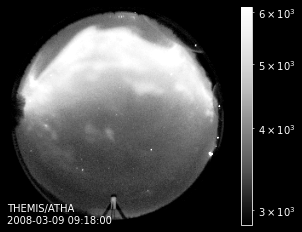

In [3]:
asi_array_code = 'THEMIS'
location_code = 'ATHA'
time = datetime(2008, 3, 9, 9, 18, 0)  # You can supply a datetime object or a ISO-formatted time string.

image_time, image, ax, im = asilib.plot_fisheye(asi_array_code, location_code, time, 
                    color_norm='log', color_map='auto')
plt.colorbar(im)
ax.axis('off');

It is also easy to map the ASI fisheye lens image to a geographic map using `asilib.plot_map`. In the code box below, the first line creates a subplot with a caropy map that surrounds Athabasca. If not provided, `asilib` will create its own map of North America. `asilib.create_cartopy_map` comes with two map styles: `white` and `green`.

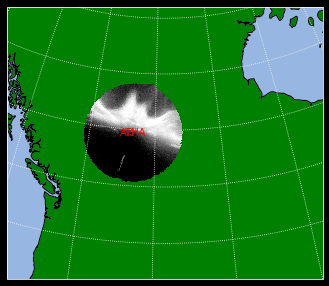

In [4]:
ax = asilib.create_cartopy_map(map_style='green', lon_bounds=(-127, -90), lat_bounds=(40, 65))

map_alt_km = 110
asilib.plot_map(asi_array_code, location_code, time, map_alt_km, ax=ax);

Notice that you did not need to explicitly download or load the data---`asilib` takes care of that for you. If you need to explicitly download data, `asilib` comes with four functions to download the image and skymap files.

Now what if you need to analyze the image? `asilib.plot_fisheye` returns the time stamp of the image `image_time` and the 2-d image np.array `image`.

In [5]:
image_time, image

(datetime.datetime(2008, 3, 9, 9, 18, 0, 51000),
 array([[2546, 2537, 2572, ..., 2554, 2616, 2536],
        [2608, 2613, 2562, ..., 2620, 2582, 2582],
        [2550, 2526, 2588, ..., 2568, 2560, 2544],
        ...,
        [2629, 2541, 2612, ..., 2553, 2546, 2525],
        [2569, 2568, 2510, ..., 2698, 2596, 2545],
        [2576, 2617, 2514, ..., 2602, 2577, 2502]], dtype=uint16))

You can also just load that image by using `asilib.load_image()`.

In [6]:
image_time, image = asilib.load_image(asi_array_code, location_code, time=time, force_download=False)

## Plot a Keogram

`asilib.plot_keogram` plots a keogram through the meridian, and using it is as simple as plotting a single image. If you don't specify a `map_alt`, the vertical axis will be pixel number. Note: `asilib.keogram` returns the keogram array that is plotted by `asilib.plot_keogram`.

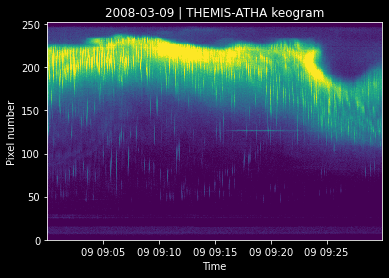

In [7]:
time_range = [datetime(2008, 3, 9, 9, 0, 0), datetime(2008, 3, 9, 9, 30, 0)]
asilib.plot_keogram(asi_array_code, location_code, time_range)
plt.xlabel('Time'); plt.ylabel('Pixel number');

And if you specify a `map_alt` (in kilometers), the vertical axis will be geographic latitude.

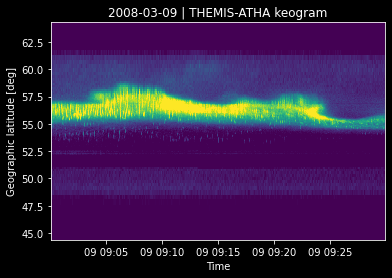

In [8]:
map_alt_km = 110
asilib.plot_keogram(asi_array_code, location_code, time_range, map_alt=map_alt_km)
plt.xlabel('Time'); plt.ylabel('Geographic latitude [deg]');

And lastly, if you specify a `map_alt` and set `aacgm=True`, the keogram's vertical axis will be magnetic latitude estimated using the [aacgmv2](https://github.com/aburrell/aacgmv2) Python package that implements the Altitude-adjusted corrected geomagnetic coordinates defined in [Shepherd 2014](https://doi.org/10.1002/2014JA020264).

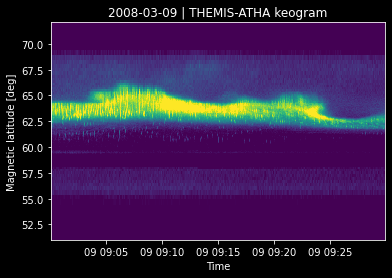

In [9]:
map_alt_km = 110
asilib.plot_keogram(asi_array_code, location_code, time_range, map_alt=map_alt_km, aacgm=True)
plt.xlabel('Time'); plt.ylabel('Magnetic latitude [deg]');

Simple enough? You can choose any other altitude from the `FULL_MAP_ALTITUDE` key in the skymap calibration data (described in the following section). If you pick a wrong altitude, `asilib` will give you a helpful error.

In [10]:
try:
    asilib.plot_keogram(asi_array_code, location_code, time_range, map_alt=100)
except AssertionError as err:
    print('AssetionError:', err)

AssetionError: 100 is not in the skymap altitudes: [ 90. 110. 150.]


These aurora-emission altitudes are in the THEMIS ASI skymap files; They are different for the REGO ASIs.

## Skymap calibration data
You may wonder how the image's pixel values were mapped to geographic latitude---this is where the skymap files come in. `asilib` also makes this easy and you only need to give it the ASI array code, location code, and the time (so the correct skymap file is loaded).

In [11]:
skymap = asilib.load_skymap(asi_array_code, location_code, time)
skymap.keys()

dict_keys(['GENERATION_INFO', 'SITE_UID', 'IMAGER_UID', 'PROJECT_UID', 'IMAGER_UNIX_TIME', 'SITE_MAP_LATITUDE', 'SITE_MAP_LONGITUDE', 'SITE_MAP_ALTITUDE', 'FULL_ROW', 'FULL_COLUMN', 'FULL_IGNORE', 'FULL_SUBTRACT', 'FULL_MULTIPLY', 'FULL_ELEVATION', 'FULL_AZIMUTH', 'FULL_MAP_ALTITUDE', 'FULL_MAP_LATITUDE', 'FULL_MAP_LONGITUDE', 'FULL_BIN', 'BIN_ROW', 'BIN_COLUMN', 'BIN_ELEVATION', 'BIN_AZIMUTH', 'BIN_MAP_ALTITUDE', 'BIN_MAP_LATITUDE', 'BIN_MAP_LONGITUDE', 'SKYMAP_PATH'])

The skymap data that `asilib` uses for keograms is the `FULL_MAP_LATITUDE`. Also, to confirm that you loaded the correct skymap file, the `skymap` dictionary contains a `SKYMAP_PATH` key that points to the local skymap file. 

In [12]:
skymap['SKYMAP_PATH']

PosixPath('/media/mike/2D6742F55A2E0A82/asilib-data/themis/skymap/atha/themis_skymap_atha_20070301-20090522_vXX.sav')

The possible skymap mapping altitudes (in meters) that you can use in `asilib.plot_keogram` and `asilib.plot_map`.

In [13]:
skymap['FULL_MAP_ALTITUDE']

array([ 90000., 110000., 150000.], dtype=float32)

## Mapping multiple all-sky images

You can plot one image from multiple ASI locations using a for-loop. In the following example, we will replicate Fig. 2b from:

Donovan, E., Liu, W., Liang, J., Spanswick, E., Voronkov, I., Connors, M., ... & Rae, I. J. (2008). Simultaneous THEMIS in situ and auroral observations of a small substorm. Geophysical Research Letters, 35(17).

/home/mike/research/aurora-asi-lib/env/lib/python3.9/site-packages/scipy/io/idl.py:281: UserWarning: Not able to verify number of bytes from header
  warnings.warn("Not able to verify number of bytes from header")


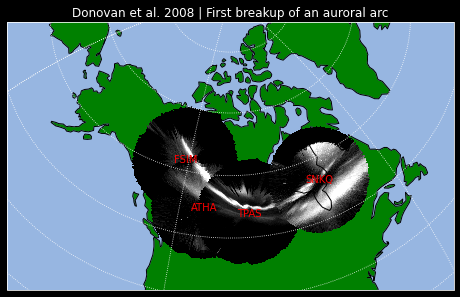

In [14]:
# ASI parameters
time = datetime(2007, 3, 13, 5, 8, 45)
asi_array_code = 'THEMIS'
location_codes = ['FSIM', 'ATHA', 'TPAS', 'SNKQ']
map_alt = 110
min_elevation = 2

bx = asilib.create_cartopy_map(map_style='green', lon_bounds=(-160, -52), lat_bounds=(40, 82))

for location_code in location_codes:
    asilib.plot_map(asi_array_code, location_code, time, map_alt, ax=bx, 
        min_elevation=min_elevation)

bx.set_title('Donovan et al. 2008 | First breakup of an auroral arc');

## Working with multiple images

The `asilib.load_image` function can also load (and automatically download) image data given a time duration specified by `time_range`. In this section, we will plot a montage of fisheye lens images that show the equatorward movement of a STEVE aurora studied in

Gallardo-Lacourt, B., Nishimura, Y., Donovan, E., Gillies, D. M., Perry, G. W., Archer, W. E., et al. (2018). A statistical analysis of STEVE. Journal of Geophysical Research: Space Physics, 123, 9893– 9905. https://doi.org/10.1029/2018JA025368

In [15]:
asi_array_code = 'REGO'
location_code = 'LUCK'
time_range = [datetime(2017, 9, 27, 7, 15), datetime(2017, 9, 27, 8, 15)]

image_times, images = asilib.load_image(asi_array_code, location_code, time_range=time_range, force_download=False)

In [16]:
image_times.shape

(1200,)

In [17]:
images.shape  # First axis is time

(1200, 512, 512)

Now lets pick 5 images from that time interval and show the movement of STEVE.

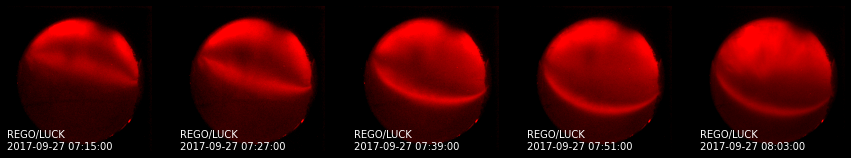

In [18]:
n_plots = 5

delta_time_s = int((time_range[1]-time_range[0]).total_seconds()/n_plots)
montage_times = [time_range[0]+timedelta(seconds=i*delta_time_s) for i in range(n_plots)]

fig, cx = plt.subplots(1, n_plots, figsize=(15, 8))

for montage_time, cx_i in zip(montage_times, cx):
    asilib.plot_fisheye(asi_array_code, location_code, montage_time, ax=cx_i)
    cx_i.axis('off')

## Make a movie

Let's now make a simple fisheye lens movie of a substorm using `asilib.animate_fisheye`.

In [19]:
asi_array_code = 'THEMIS'
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 7, 0), datetime(2015, 3, 26, 6, 30, 0)]

# loglevel is to suppress the verbose ffmpeg output.
asilib.animate_fisheye(asi_array_code, location_code, time_range, overwrite=True, ffmpeg_output_params={'loglevel':'quiet'})
plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/aurora-asi-lib/blob/e6147ff1a3309c602c1aa48711ebc8a90a7863e1/docs/_static/'
    '20150326_060700_062957_themis_fsmi.mp4?raw=true')

Created a /media/mike/2D6742F55A2E0A82/asilib-data/animations/images/20150326_060700_themis_fsmi_fisheye directory


Animating images into the ionosphere is also straightforward. 

In [20]:
asi_array_code = 'THEMIS'
location_code = 'FSMI'
time_range = [datetime(2015, 3, 26, 6, 7, 0), datetime(2015, 3, 26, 6, 30, 0)]

# We need the skymap only to center the map on the projected image.
skymap = asilib.load_skymap(asi_array_code, location_code, time_range[0])
lat_bounds = (skymap['SITE_MAP_LATITUDE']-7, skymap['SITE_MAP_LATITUDE']+7)
lon_bounds = (skymap['SITE_MAP_LONGITUDE']-20, skymap['SITE_MAP_LONGITUDE']+20)

ax = asilib.create_cartopy_map(map_style='green', lon_bounds=lon_bounds, lat_bounds=lat_bounds)
asilib.animate_map(asi_array_code, location_code, time_range, 110, overwrite=True, ax=ax, 
    ffmpeg_output_params={'loglevel':'quiet'})

plt.close()  # To show a clean output in this tutorial---it is often unnecessary.

# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/aurora-asi-lib/blob/mike_dev/docs/_static/'
    '20150326_060700_061157_themis_fsmi_map.mp4?raw=true')

Created a /media/mike/2D6742F55A2E0A82/asilib-data/animations/images/20150326_060700_themis_fsmi_map directory


In the next section, we make a more sophisticated movie using `asilib.animate_fisheye_generator`.

## Satellite conjunction

As a last example, here we show how `asilib` can be used to make a conjunction movie. Be forewarned, this example is long. We will use ASI data from the THEMIS-RANK imager.

In [21]:
asi_array_code = 'THEMIS'
location_code = 'RANK'
time_range = (datetime(2017, 9, 15, 2, 32, 0), datetime(2017, 9, 15, 2, 35, 0))

Now we define an orbit path of a low Earth orbiting satellite. In this context, `lla` stands for the `(latitude, longitude, altitude)` coordinates. That we place near the THEMIS-RANK imager, hence we use load_skymap to extract the imager's location in Canada.

In [22]:
# Load the skymap calibration data. This is necessary to create the satellite track overhead.
skymap_dict = asilib.load_skymap(asi_array_code, location_code, time_range[0])

# Create the fake satellite track coordinates: latitude, longitude, altitude (LLA).
# This is a north-south satellite track oriented to the east of the THEMIS/RANK
# imager.
n = int((time_range[1] - time_range[0]).total_seconds() / 3)  # 3 second cadence.
lats = np.linspace(skymap_dict["SITE_MAP_LATITUDE"] + 5, skymap_dict["SITE_MAP_LATITUDE"] - 5, n)
lons = (skymap_dict["SITE_MAP_LONGITUDE"] - 0.5) * np.ones(n)
alts = 110 * np.ones(n)
lla = np.array([lats, lons, alts]).T

With the satellite track, we first need to map its location to the imager's elevation and azimuth (azel) using `asilib.lla2azel`. Note: if you need to find the satellite's footprint, you can use `asilib.lla2footprint` to map along the magnetic field line before you pass the footprint LLA into `asilib.lla2azel`. However, `asilib.lla2footprint` requires the [IRBEM](https://github.com/PRBEM/IRBEM) library.

In [23]:
sat_azel, sat_azel_pixels = asilib.lla2azel(asi_array_code, location_code, time_range[0], lla)

Here we create the conjunction movie. We can't easily split up the steps into notebook cells, but I've add STEPS 1-4 for the main steps:

- STEP 1: create the subplots. ax[0] will plot the ASI images, while ax[1] will plot the ASI intensity time series along the satellite path. We initialize the `asilib.animate_fisheye_generator` function which allows us to manipulate the individual images before they are stitched together into a movie.

- STEP 2: We retrieve the imager time stamps and images using `movie_generator` (technically it is a `coroutine`). We need this to calculate the mean ASI intensity along the spacecraft track.

- STEP 3: We use `asilib.equal_area` to calculate the pixels inside a 20x20 km area at 110 km around the satellite's footprint (inferred from LLA). `asilib.equal_area` returns a mask: 1s inside the area, and NaNs outside it. We use it with `image_data.images` and `np.nanmean` to calculate the mean ASI intensity in all frames simultaneously.

- STEP 4: Loop over every image in `time_range`. `asilib.animate_fisheye_generator` will plot the current frame in `ax[0]` on top of which we superpose the full satellite track and its current location. We also use `plt.contour` to plot the 20x20 km area at 110 km in yellow. Lastly, in `ax[1]` we plot the mean ASI time series in the area box around the satelite's footprint, as well as a vertical line to guide your eye to the corresponding image in `ax[0]`.

In [24]:
# STEP 1
fig, ax = plt.subplots(
    2, 1, figsize=(7, 10), gridspec_kw={'height_ratios': [4, 1]}, constrained_layout=True
)
movie_generator = asilib.animate_fisheye_generator(
    asi_array_code, location_code, time_range, azel_contours=True, overwrite=True, ax=ax[0],
    ffmpeg_output_params={'loglevel':'quiet'}
)

# STEP 2
# Use the generator to get the images and time stamps to estimate mean the ASI
# brightness along the satellite path and in a (10x10 km) box.
image_data = movie_generator.send('data')

# STEP 3
# Calculate what pixels are in a box_km around the satellite, and convolve it
# with the images to pick out the ASI intensity in that box.
area_box_mask = asilib.equal_area(
    asi_array_code, location_code, time_range[0], lla, box_km=(20, 20)
)
asi_brightness = np.nanmean(image_data.images * area_box_mask, axis=(1, 2))
area_box_mask[np.isnan(area_box_mask)] = 0  # To play nice with plt.contour()

# STEP 4
for i, (time, image, _, im) in enumerate(movie_generator):
    # Note that because we are drawing moving data: ASI image in ax[0] and
    # the ASI time series + a vertical bar at the image time in ax[1], we need
    # to redraw everything at every iteration.

    # Clear ax[1] (ax[0] cleared by asilib.animate_fisheye_generator())
    ax[1].clear()
    # Plot the entire satellite track
    ax[0].plot(sat_azel_pixels[:, 0], sat_azel_pixels[:, 1], 'red')
    ax[0].contour(area_box_mask[i, :, :], levels=[0.99], colors=['yellow'])
    # Plot the current satellite position.
    ax[0].scatter(sat_azel_pixels[i, 0], sat_azel_pixels[i, 1], c='red', marker='o', s=50)

    # Plot the time series of the mean ASI intensity along the satellite path
    ax[1].plot(image_data.time, asi_brightness)
    ax[1].axvline(time, c='b')  # At the current image time.

    # Annotate the location_code and satellite info in the top-left corner.
    location_code_str = (
        f'{asi_array_code}/{location_code} '
        f'LLA=({skymap_dict["SITE_MAP_LATITUDE"]:.2f}, '
        f'{skymap_dict["SITE_MAP_LONGITUDE"]:.2f}, {skymap_dict["SITE_MAP_ALTITUDE"]:.2f})'
    )
    satellite_str = f'Satellite LLA=({lla[i, 0]:.2f}, {lla[i, 1]:.2f}, {lla[i, 2]:.2f})'
    ax[0].text(
        0,
        1,
        location_code_str + '\n' + satellite_str,
        va='top',
        transform=ax[0].transAxes,
        color='red',
    )
    ax[1].set(xlabel='Time', ylabel='Mean ASI intensity [counts]')

print(f'Movie saved in {asilib.config["ASI_DATA_DIR"] / "movies"}')
plt.close()

Created a /media/mike/2D6742F55A2E0A82/asilib-data/animations/images/20170915_023200_themis_rank_fisheye directory
Movie saved in /media/mike/2D6742F55A2E0A82/asilib-data/movies


In [25]:
# When you run this, you should see the video below in your asilib-data/movies directory.
Video('https://github.com/mshumko/aurora-asi-lib/blob/main/docs/_static/20170915_023200_023457_themis_rank.mp4?raw=true')